# Amplitude Matching for Multizone Sound Field Control

A multizone sound field control method to synthesize a desired amplitude (or magnitude) distributions over a target region with multiple loudspeakers
- Paper: https://doi.org/10.1109/TASLP.2022.3231715
- Codes: https://github.com/sh01k/AmplitudeMatching

by Takumi Abe, [Shoichi Koyama](https://www.sh01.org/), [Natsuki Ueno](https://natsuenono.github.io/), and [Hiroshi Saruwatari](https://researchmap.jp/read0102891/)

## Codes for reproducing results in Sect. IV-B
### General settings

In [185]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as distfuncs
from scipy import optimize
from scipy import stats
from scipy import fft

import sf_func as sf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
plt.rcParams["font.size"] = 18 # Font size for plots

c = 340 # Sound speed (m/s)

# Simulated rectangular region 
lenX = 4.0 # Length in y
lenY = 4.0 # Length in y

dx, dy = 0.05, 0.05 # Intervals

# Simulated positions
xvecSim = np.arange(-lenX/2.0, lenX/2.0 + dx, dx)
yvecSim = np.arange(-lenY/2.0, lenY/2.0 + dy, dy)
ySim, xSim = np.meshgrid(yvecSim, xvecSim)
posSim = np.concatenate([xSim.reshape([-1,1]), ySim.reshape([-1,1])], 1)

# Number of simulated positions
numSimX = xSim.shape[0]
numSimY = xSim.shape[1]
numSim = (numSimX, numSimY)

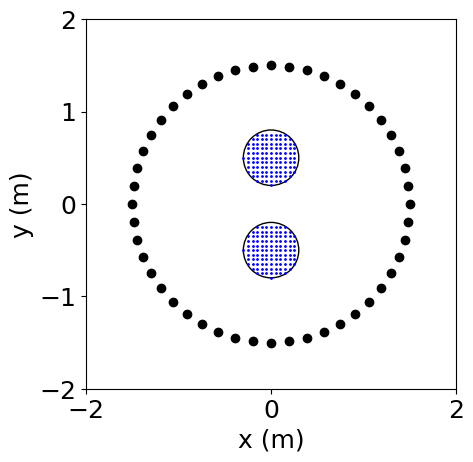

In [187]:
"""Parameters"""
radSPK = 1.5 # Radius of circlular loudspeaker array
numSPK = 48 # Number of loudspeakers
posSPK = sf.CircularGrid(radSPK, numSPK) # Loudspeaker positions

radCP = 0.3 # Radius of circular target regions
centCP_U = np.array([0.0, 0.5])[None,:] # Center position of upper target region
centCP_L = np.array([0.0, -0.5])[None,:] # Center position of lower target region
centCP = np.concatenate([centCP_U, centCP_L], 0)

# Control points in upper target region
distCP_U = distfuncs.cdist(posSim, centCP_U)
idxCP_U = np.where(distCP_U <= radCP)[0]
posCP_U = posSim[idxCP_U, :] 
numCP_U = posCP_U.shape[0]

# Control points in lower target region
distCP_L = distfuncs.cdist(posSim, centCP_L)
idxCP_L = np.where(distCP_L <= radCP)[0]
posCP_L = posSim[idxCP_L, :] 
numCP_L = posCP_L.shape[0]

idxCP = np.concatenate([idxCP_U, idxCP_L]) # Indexes of total control points
posCP = posSim[idxCP, :] # Position of total control points
numCP = posCP.shape[0] # Number of control points

# Desired amplitude distribution
des_U = np.ones(numCP_U)
des_L = np.zeros(numCP_L)
des = np.concatenate([des_U, des_L])

# Draw points
fig, ax = plt.subplots()
ax.scatter(posSPK[:,0], posSPK[:,1], c='k')
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posCP[:,0], posCP[:,1], s=1, c='b')
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

### Figures 12, 13, and 14: Time-domain filters and their magnitude and pahse responses

In [188]:
"""Parameters"""
numFreq = 16384 #1024 #
freqVec = np.linspace(0, 8000, numFreq+1)[1:]
k = 2.0 * np.pi * freqVec / c # Wave number

idxEval = 10 # Loudspeaker index used for evaluation

# Transfer Function Matrices
G = sf.TransFuncMat(posSPK, posCP, k[:,None,None])
#GU = sf.TransFuncMat(posSPK, posCP_U, k[:,None,None]) # For upper target region
#GL = sf.TransFuncMat(posSPK, posCP_L, k[:,None,None]) # For lower target region

# Regularization parameter
U, s, V = np.linalg.svd(np.transpose(G.conj(),(0,2,1)) @ G)
reg = np.max(s, axis=1) * 1e-3

In [189]:
"""Pressure matching (PM) with zero phase"""
drvPM0 = sf.PressureMatching(G, reg[:,None,None], posSPK, des[None,:,None])

In [190]:
"""Amplitude matching with l2-norm penalty"""
# Parameters
dtol = 1e-3
max_iter = 1000

drvAM_ADMM_l2 = np.zeros([numFreq, numSPK]).astype("complex")
for i in range(numFreq):
    print("i: %d, freq: %f" % (i, freqVec[i]) )
    Gi = np.squeeze(G[i,:,:])
    regi = np.squeeze(reg[i])
    drv0 = np.squeeze(drvPM0[i,:])
    drvAM_ADMM_l2[i,:], _ = sf.ADMM(numSPK, des, Gi, regi, drv0, max_iter=max_iter, dtol=dtol)

i: 0, freq: 0.488281
i: 1, freq: 0.976562
i: 2, freq: 1.464844
i: 3, freq: 1.953125
i: 4, freq: 2.441406
i: 5, freq: 2.929688
i: 6, freq: 3.417969
i: 7, freq: 3.906250
i: 8, freq: 4.394531
i: 9, freq: 4.882812
i: 10, freq: 5.371094
i: 11, freq: 5.859375
i: 12, freq: 6.347656
i: 13, freq: 6.835938
i: 14, freq: 7.324219
i: 15, freq: 7.812500
i: 16, freq: 8.300781
i: 17, freq: 8.789062
i: 18, freq: 9.277344
i: 19, freq: 9.765625
i: 20, freq: 10.253906
i: 21, freq: 10.742188
i: 22, freq: 11.230469
i: 23, freq: 11.718750
i: 24, freq: 12.207031
i: 25, freq: 12.695312
i: 26, freq: 13.183594
i: 27, freq: 13.671875
i: 28, freq: 14.160156
i: 29, freq: 14.648438
i: 30, freq: 15.136719
i: 31, freq: 15.625000
i: 32, freq: 16.113281
i: 33, freq: 16.601562
i: 34, freq: 17.089844
i: 35, freq: 17.578125
i: 36, freq: 18.066406
i: 37, freq: 18.554688
i: 38, freq: 19.042969
i: 39, freq: 19.531250
i: 40, freq: 20.019531
i: 41, freq: 20.507812
i: 42, freq: 20.996094
i: 43, freq: 21.484375
i: 44, freq: 21.97

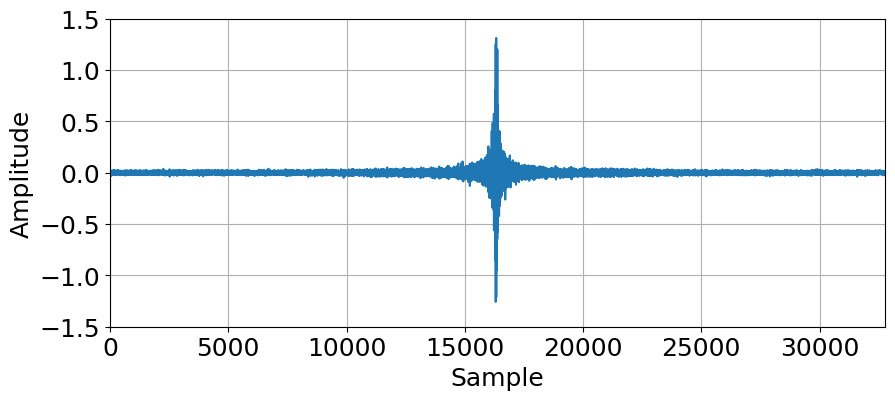

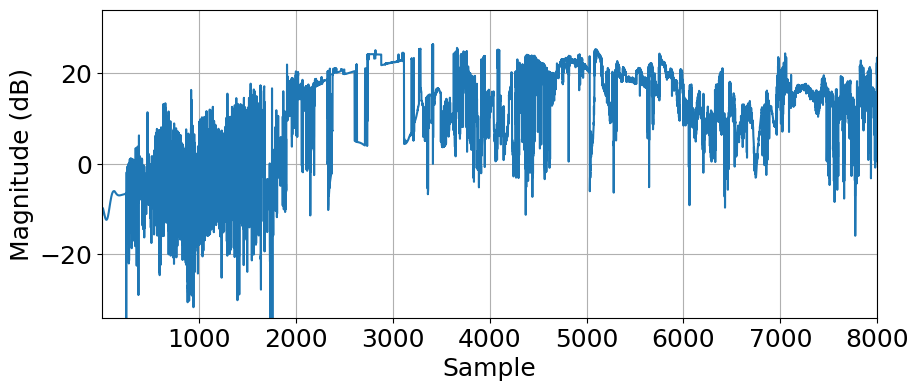

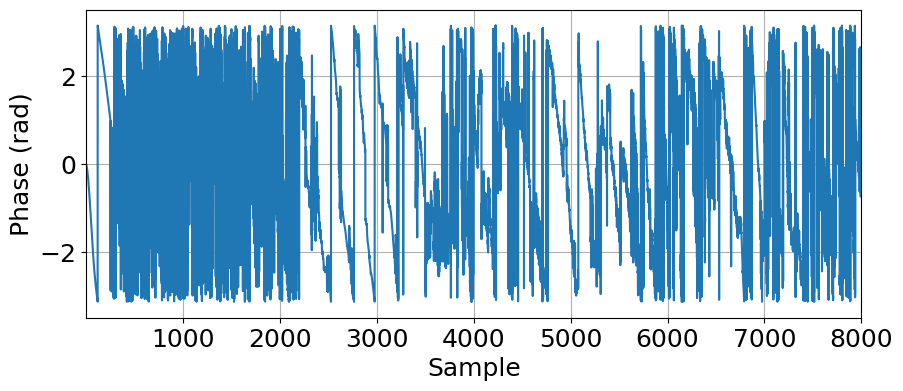

In [191]:
fftlen = numFreq*2
filterLen = fftlen
smplShift = int(fftlen/2)

specAM_ADMM_l2 = np.concatenate( (np.zeros((1,numSPK)), drvAM_ADMM_l2, drvAM_ADMM_l2[int(fftlen/2)-2::-1,:].conj()) )
sigAM_ADMM_l2 = np.fft.ifft(specAM_ADMM_l2.conj(), n=fftlen, axis=0).real
sigAM_ADMM_l2 = np.concatenate( (sigAM_ADMM_l2[fftlen-smplShift:fftlen,:], sigAM_ADMM_l2[:filterLen-smplShift,:]) )

# Plot filter
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(sigAM_ADMM_l2[:,idxEval])
ax.set_xlim(0,fftlen)
ax.set_ylim(-1.5,1.5)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Amplitude')

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(freqVec, 20*np.log10( np.abs(drvAM_ADMM_l2[:,idxEval]) ))
ax.set_xlim(np.min(freqVec),np.max(freqVec))
ax.set_ylim(-34,34)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Magnitude (dB)')

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(freqVec, np.angle(drvAM_ADMM_l2[:,idxEval]) )
ax.set_xlim(np.min(freqVec),np.max(freqVec))
ax.set_ylim(-3.5,3.5)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Phase (rad)')

plt.show()

In [193]:
"""Amplitude matching with differential-norm penalty"""
# Parameters
dtol = 1e-3
max_iter = 1000

regDiff = 25 

drvAM_ADMM_diff = sf.ADMMdiff(numSPK, numCP, numFreq, des, regDiff, drvPM0, G, max_iter=max_iter, dtol=dtol)

Balancer:  8192
Initializing......
itr: 0, ddiff: 1.161359
itr: 1, ddiff: 0.704498
itr: 2, ddiff: 0.445642
itr: 3, ddiff: 0.327184
itr: 4, ddiff: 0.254147
itr: 5, ddiff: 0.197115
itr: 6, ddiff: 0.188452
itr: 7, ddiff: 0.145804
itr: 8, ddiff: 0.142460
itr: 9, ddiff: 0.120782
itr: 10, ddiff: 0.123657
itr: 11, ddiff: 0.110933
itr: 12, ddiff: 0.110315
itr: 13, ddiff: 0.101335
itr: 14, ddiff: 0.094272
itr: 15, ddiff: 0.094269
itr: 16, ddiff: 0.090935
itr: 17, ddiff: 0.093355
itr: 18, ddiff: 0.084461
itr: 19, ddiff: 0.087491
itr: 20, ddiff: 0.081019
itr: 21, ddiff: 0.083749
itr: 22, ddiff: 0.077250
itr: 23, ddiff: 0.075696
itr: 24, ddiff: 0.070635
itr: 25, ddiff: 0.067755
itr: 26, ddiff: 0.063432
itr: 27, ddiff: 0.064811
itr: 28, ddiff: 0.061097
itr: 29, ddiff: 0.065018
itr: 30, ddiff: 0.061690
itr: 31, ddiff: 0.065115
itr: 32, ddiff: 0.061180
itr: 33, ddiff: 0.061152
itr: 34, ddiff: 0.060415
itr: 35, ddiff: 0.057546
itr: 36, ddiff: 0.056076
itr: 37, ddiff: 0.052679
itr: 38, ddiff: 0.052197


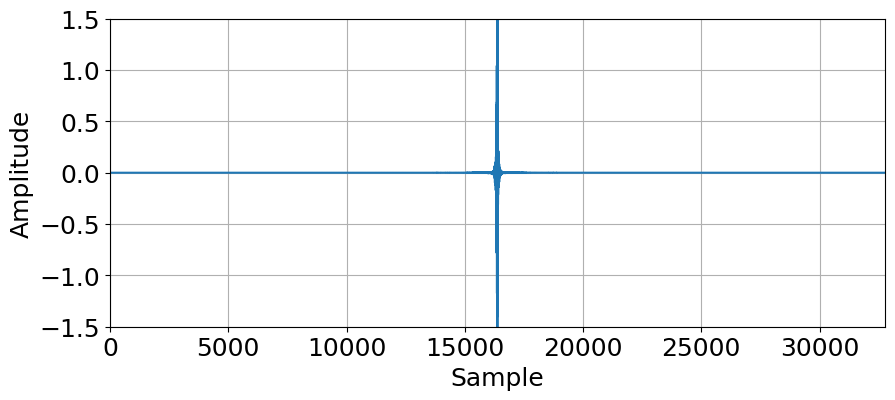

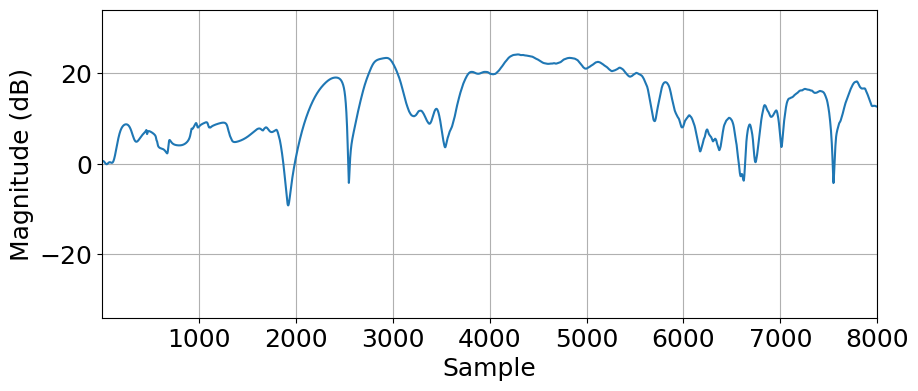

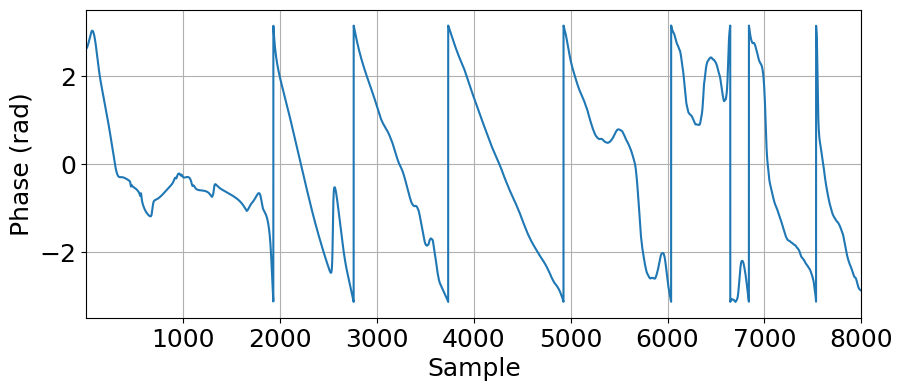

In [194]:
fftlen = numFreq*2
filterLen = fftlen
smplShift = int(fftlen/2)

specAM_ADMM_diff = np.concatenate( (np.zeros((1,numSPK)), drvAM_ADMM_diff, drvAM_ADMM_diff[int(fftlen/2)-2::-1,:].conj()) )
sigAM_ADMM_diff = np.fft.ifft(specAM_ADMM_diff.conj(), n=fftlen, axis=0).real
sigAM_ADMM_diff = np.concatenate( (sigAM_ADMM_diff[fftlen-smplShift:fftlen,:], sigAM_ADMM_diff[:filterLen-smplShift,:]) )

# Plot filter
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(sigAM_ADMM_diff[:,idxEval])
ax.set_xlim(0,fftlen)
ax.set_ylim(-1.5,1.5)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Amplitude')

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(freqVec, 20*np.log10( np.abs(drvAM_ADMM_diff[:,idxEval]) ))
ax.set_xlim(np.min(freqVec),np.max(freqVec))
ax.set_ylim(-34,34)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Magnitude (dB)')

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(freqVec, np.angle(drvAM_ADMM_diff[:,idxEval]) )
ax.set_xlim(np.min(freqVec),np.max(freqVec))
ax.set_ylim(-3.5,3.5)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Phase (rad)')

plt.show()

In [200]:
#np.save('drvAM_ADMM_l2', drvAM_ADMM_l2)
#np.save('drvAM_ADMM_diff', drvAM_ADMM_diff)
np.load('drvAM_ADMM_l2')
np.load('drvAM_ADMM_diff')

In [195]:
"""Filter length"""
pwavAM_ADMM_l2 = 10*np.log10( np.sum( np.abs(sigAM_ADMM_l2)**2, axis=1 ) )
idxPeak_l2 = np.argmax( pwavAM_ADMM_l2 ) #np.argmax( np.abs(sigAM_ADMM_l2[:,idxEval]) )
magPeak_l2 = pwavAM_ADMM_l2[idxPeak_l2] # 10*np.log10(np.abs(sigAM_ADMM_l2[idxPeak_l2,idxEval])**2)
idxPeak30_l2 = np.where( pwavAM_ADMM_l2 > (magPeak_l2 - 30.0) )[0] #np.where( 10*np.log10(np.abs(sigAM_ADMM_l2[:,idxEval])**2) > (magPeak_l2 - 30.0) )[0]
idxTrun_l2 = range(np.min(idxPeak30_l2), np.max(idxPeak30_l2))
filterLen_l2 = len(idxTrun_l2)
print("filterLen (l2): ", filterLen_l2)

pwavAM_ADMM_diff = 10*np.log10( np.sum( np.abs(sigAM_ADMM_diff)**2, axis=1 ) )
idxPeak_diff = np.argmax( pwavAM_ADMM_diff ) #np.argmax( np.abs(sigAM_ADMM_diff[:,idxEval]) )
magPeak_diff = pwavAM_ADMM_diff[idxPeak_diff] # 10*np.log10(np.abs(sigAM_ADMM_diff[idxPeak_diff,idxEval])**2)
idxPeak30_diff = np.where( pwavAM_ADMM_diff > (magPeak_diff - 30.0) )[0] # np.where( 10*np.log10(np.abs(sigAM_ADMM_diff[:,idxEval])**2) > (magPeak_diff - 30.0) )[0]
idxTrun_diff = range(np.min(idxPeak30_diff), np.max(idxPeak30_diff))
filterLen_diff = len(idxTrun_diff)
print("filterLen (diff): ", filterLen_diff)

filterLen (l2):  8782
filterLen (diff):  179


### Figure 15: Performance in broadband case

smplShift:  110
smplShift:  110


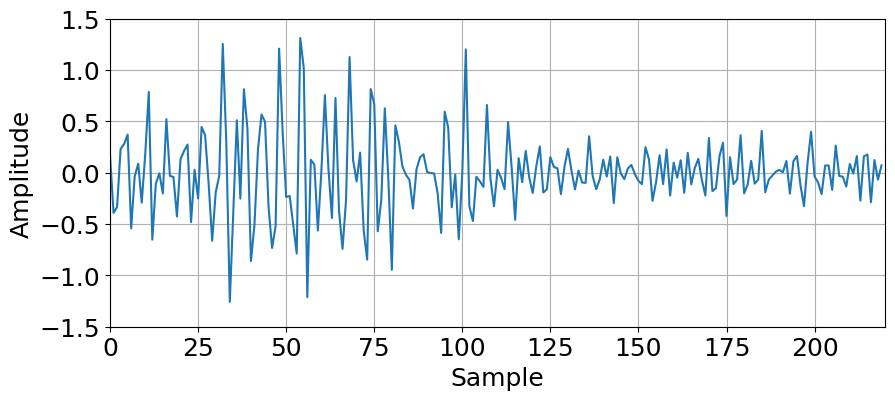

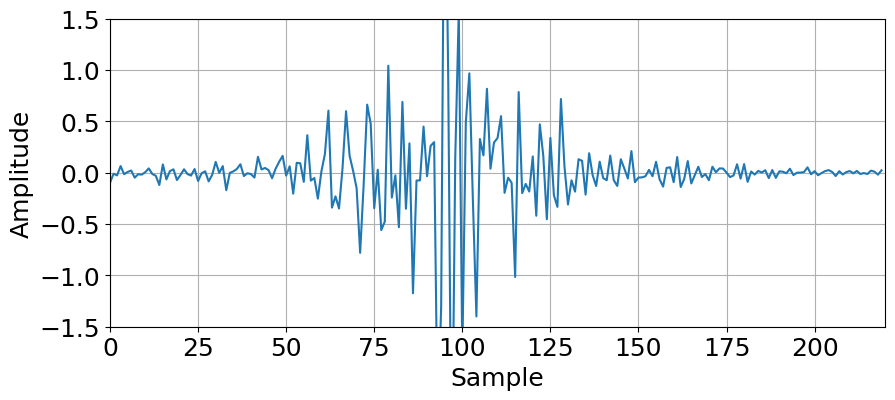

In [196]:
"""Compute filters"""
filterLen = 220

smplShift = int( filterLen/2 ) #int( filterLen/2 - (idxPeak_l2 - fftlen/2) )
print("smplShift: ", smplShift)
filterAM_ADMM_l2 = np.fft.ifft(specAM_ADMM_l2.conj(), n=fftlen, axis=0).real
filterAM_ADMM_l2 = np.concatenate( (filterAM_ADMM_l2[fftlen-smplShift:fftlen,:], filterAM_ADMM_l2[:filterLen-smplShift,:]) )

smplShift = int( filterLen/2 ) #int( filterLen/2 - (idxPeak_diff - fftlen/2) )
print("smplShift: ", smplShift)
filterAM_ADMM_diff = np.fft.ifft(specAM_ADMM_diff.conj(), n=fftlen, axis=0).real
filterAM_ADMM_diff = np.concatenate( (filterAM_ADMM_diff[fftlen-smplShift:fftlen,:], filterAM_ADMM_diff[:filterLen-smplShift,:]) )

# Plot filter
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(filterAM_ADMM_l2[:,idxEval])
ax.set_xlim(0,filterLen)
ax.set_ylim(-1.5,1.5)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Amplitude')

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(filterAM_ADMM_diff[:,idxEval])
ax.set_xlim(0,filterLen)
ax.set_ylim(-1.5,1.5)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.show()

Text(0, 0.5, 'y (m)')

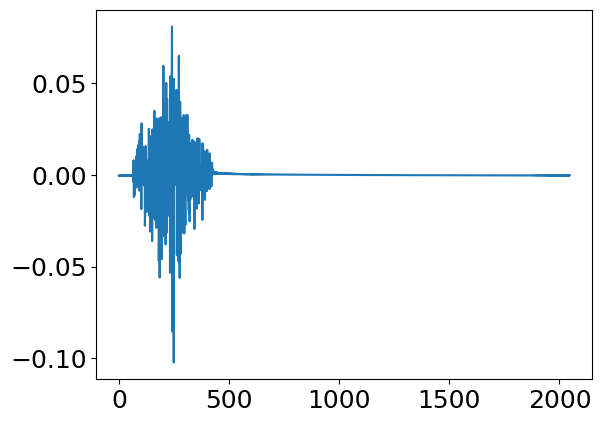

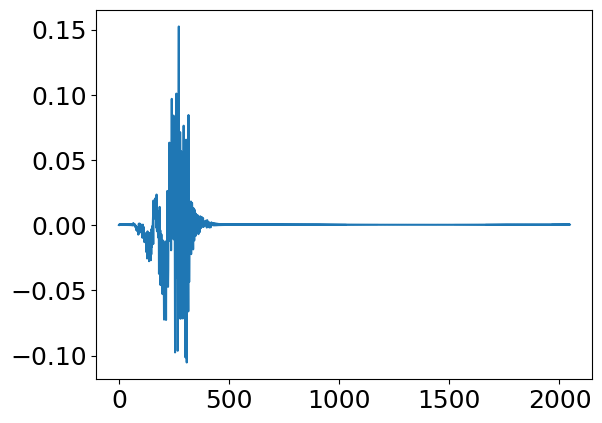

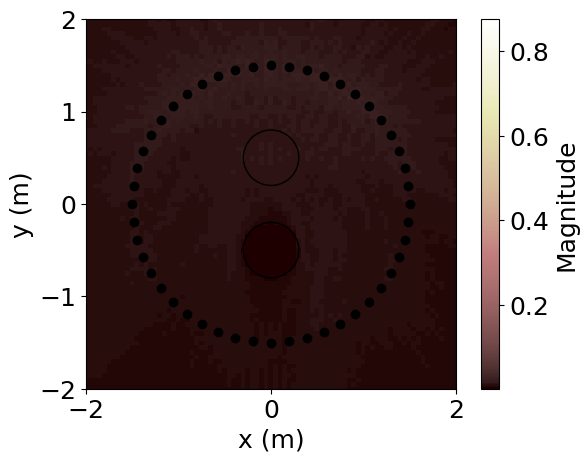

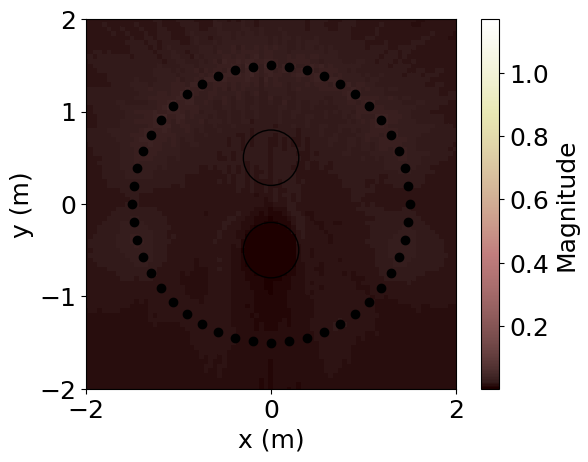

In [197]:
"""Synthesized sound field"""
fftlen = 2048
smplShift = int(fftlen/2)
numFreq = int(fftlen/2)
freqVec_syn = np.linspace(0, 8000, numFreq+1)[1:]
k = 2.0 * np.pi * freqVec_syn / c # Wave number

# AM w/ l2-norm penalty
fltspecAM_ADMM_l2 = np.fft.fft(filterAM_ADMM_l2, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]
synspecAM_ADMM_l2, _ = sf.SynthSoundField(posSim, posSPK, fltspecAM_ADMM_l2.conj(), numSim, k)
synspecAM_ADMM_l2 = np.concatenate( (np.zeros((1,numSim[0]*numSim[1])), synspecAM_ADMM_l2, synspecAM_ADMM_l2[int(fftlen/2)-2::-1,:].conj()) )
synAM_ADMM_l2 = np.fft.ifft(synspecAM_ADMM_l2.conj(), n=fftlen, axis=0).real
synpwAM_ADMM_l2 = np.sqrt( np.sum(np.abs(synAM_ADMM_l2)**2, axis=0) / synAM_ADMM_l2.shape[0] )
synpwAM_ADMM_l2_XY = synpwAM_ADMM_l2.reshape(numSim[0], numSim[1])

# AM w/ differential-norm penalty
fltspecAM_ADMM_diff = np.fft.fft(filterAM_ADMM_diff, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]
synspecAM_ADMM_diff, _= sf.SynthSoundField(posSim, posSPK, fltspecAM_ADMM_diff.conj(), numSim, k)
synspecAM_ADMM_diff = np.concatenate( (np.zeros((1,numSim[0]*numSim[1])), synspecAM_ADMM_diff, synspecAM_ADMM_diff[int(fftlen/2)-2::-1,:].conj()) )
synAM_ADMM_diff = np.fft.ifft(synspecAM_ADMM_diff.conj(), n=fftlen, axis=0).real
synpwAM_ADMM_diff = np.sqrt( np.sum(np.abs(synAM_ADMM_diff)**2, axis=0) / synAM_ADMM_diff.shape[0] )
synpwAM_ADMM_diff_XY = synpwAM_ADMM_diff.reshape(numSim[0], numSim[1])

fig, ax = plt.subplots()
ax.plot(synAM_ADMM_l2[:,0])

fig, ax = plt.subplots()
ax.plot(synAM_ADMM_diff[:,0])

fig, ax = plt.subplots()
#color = ax.pcolor(xSim, ySim, synpwAM_ADMM_l2_XY, cmap='pink', vmin=0.0, vmax=1.2)
color = ax.pcolor(xSim, ySim, synpwAM_ADMM_l2_XY, cmap='pink')
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
#color = ax.pcolor(xSim, ySim, synpwAM_ADMM_diff_XY, cmap='pink', vmin=0.0, vmax=1.2)
color = ax.pcolor(xSim, ySim, synpwAM_ADMM_diff_XY, cmap='pink')
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

AD w/ l2-norm: -9.9, AM w/ Diff. norm: -16.9


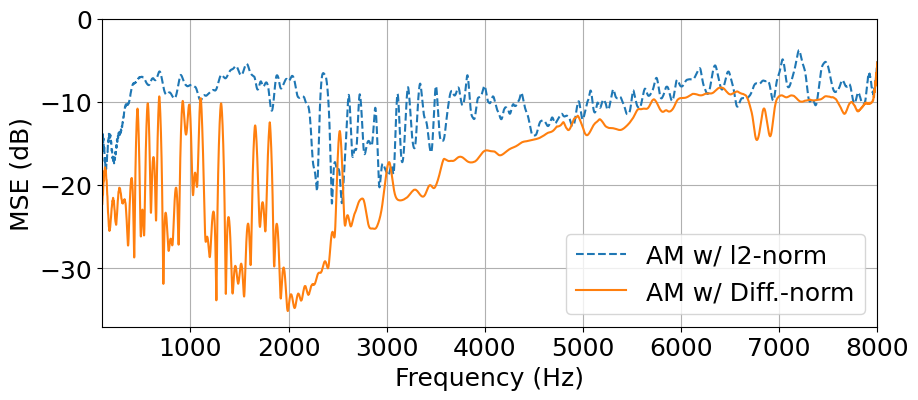

In [198]:
"""Evaluation"""
fftlen = 32768
numFreq = int(fftlen/2)
freqVec_eval = np.linspace(0, 8000, numFreq+1)[1:]
synspecAM_ADMM_l2 = np.fft.fft(synAM_ADMM_l2, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]
synspecAM_ADMM_diff = np.fft.fft(synAM_ADMM_diff, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]

MSEvec_AM_ADMM_l2 = []
MSEvec_AM_ADMM_diff = []

for i in range(numFreq):
    MSEvec_AM_ADMM_l2.append(sf.MSE(synspecAM_ADMM_l2[i,idxCP], des))
    MSEvec_AM_ADMM_diff.append(sf.MSE(synspecAM_ADMM_diff[i,idxCP], des))

MSEav_AM_ADMM_l2 = np.average(MSEvec_AM_ADMM_l2)
MSEav_AM_ADMM_diff = np.average(MSEvec_AM_ADMM_diff)

print("AD w/ l2-norm: %.1f, AM w/ Diff. norm: %.1f" % (MSEav_AM_ADMM_l2, MSEav_AM_ADMM_diff) )

# Plot
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(freqVec_eval, MSEvec_AM_ADMM_l2, linestyle="--", label="AM w/ l2-norm")
ax.plot(freqVec_eval, MSEvec_AM_ADMM_diff, linestyle="-", label="AM w/ Diff.-norm")
ax.set_xlim(100,8000)
ax.set_ylim(-37, 0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('MSE (dB)')
plt.legend()
plt.grid()